In [19]:
import csv
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.stats import spearmanr, pearsonr
import seaborn as sns

In [4]:
# Calculating bout durations from individual csv

def calculate_bout_durations_from_csv(file_path):
    """
    Calculate bout durations for each sleep stage based on continuous values from a CSV file.

    Args:
        file_path (str): Path to the CSV file. The file must have columns `Timestamp` and `sleepStage`.

    Returns:
        list: A list of dictionaries where each dictionary represents a bout with `Timestamp`, `Duration`, `sleepStage`, and `ZT`.
    """
    def calculate_zt(timestamp):
        """
        Calculate the ZT (Zeitgeber Time) based on the timestamp.
        ZT 0 corresponds to 09:00:00 and ZT 12 corresponds to 21:00:00.

        Args:
            timestamp (str): Timestamp in the format 'HH:MM:SS'.

        Returns:
            float: The ZT value.
        """
        base_time = datetime.strptime("09:00:00", "%H:%M:%S")
        current_time = datetime.strptime(timestamp.split()[1], "%H:%M:%S")
        delta = current_time - base_time

        if delta.days < 0:  # Handle times past midnight
            delta += timedelta(days=1)

        zt = (delta.total_seconds() / 3600) % 24
        return zt

    # Read the data from the CSV
    with open(file_path, mode='r') as file:
        reader = csv.DictReader(file)
        data = [(row['Timestamp'], int(row['sleepStage'])) for row in reader]

    if not data:
        return []

    # Initialize variables
    bouts = []
    start_timestamp = data[0][0]  # Start timestamp of the current bout
    current_stage = data[0][1]   # Current sleep stage
    bout_length = 1              # Length of the current bout

    # Iterate through the data starting from the second element
    for i in range(1, len(data)):
        timestamp, sleep_stage = data[i]

        if sleep_stage == current_stage:
            # Increment bout length if the stage is continuous
            bout_length += 1
        else:
            # Append the bout as a dictionary
            bouts.append({
                'Timestamp': start_timestamp,
                'Duration': bout_length,
                'sleepStage': current_stage,
                'ZT': calculate_zt(start_timestamp)
            })

            # Reset for the next bout
            start_timestamp = timestamp
            current_stage = sleep_stage
            bout_length = 1

    # Add the final bout to the result
    bouts.append({
        'Timestamp': start_timestamp,
        'Duration': bout_length,
        'sleepStage': current_stage,
        'ZT': calculate_zt(start_timestamp)
    })

    return bouts

# Example usage:
file_path = "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-007_ses-01_recording-01_time-0-70.5h_sr-1hz.csv"  # Replace with the path to your CSV file
bout_durations = calculate_bout_durations_from_csv(file_path)
print(bout_durations)


[{'Timestamp': '2024-07-02 15:13:11', 'Duration': 283, 'sleepStage': 1, 'ZT': 6.219722222222222}, {'Timestamp': '2024-07-02 15:17:54', 'Duration': 86, 'sleepStage': 2, 'ZT': 6.298333333333333}, {'Timestamp': '2024-07-02 15:19:20', 'Duration': 32, 'sleepStage': 3, 'ZT': 6.322222222222222}, {'Timestamp': '2024-07-02 15:19:52', 'Duration': 3, 'sleepStage': 1, 'ZT': 6.331111111111111}, {'Timestamp': '2024-07-02 15:19:55', 'Duration': 58, 'sleepStage': 2, 'ZT': 6.331944444444445}, {'Timestamp': '2024-07-02 15:20:53', 'Duration': 320, 'sleepStage': 1, 'ZT': 6.348055555555556}, {'Timestamp': '2024-07-02 15:26:13', 'Duration': 34, 'sleepStage': 2, 'ZT': 6.436944444444444}, {'Timestamp': '2024-07-02 15:26:47', 'Duration': 412, 'sleepStage': 1, 'ZT': 6.4463888888888885}, {'Timestamp': '2024-07-02 15:33:39', 'Duration': 7, 'sleepStage': 2, 'ZT': 6.560833333333333}, {'Timestamp': '2024-07-02 15:33:46', 'Duration': 11, 'sleepStage': 1, 'ZT': 6.562777777777778}, {'Timestamp': '2024-07-02 15:33:57', 

Sleep Stage 1: Pearson Correlation = 0.05, Spearman Correlation = 0.01


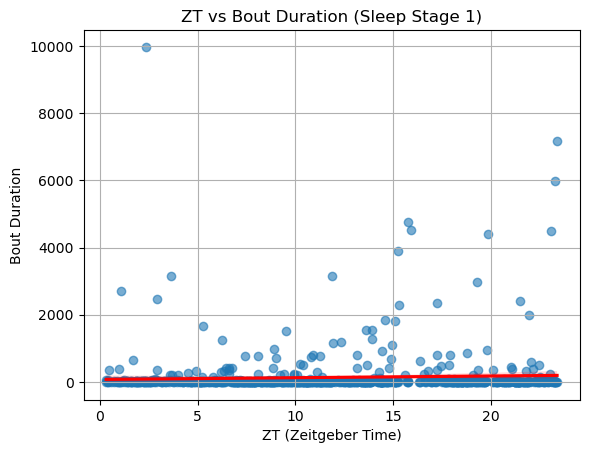

Sleep Stage 2: Pearson Correlation = -0.01, Spearman Correlation = -0.03


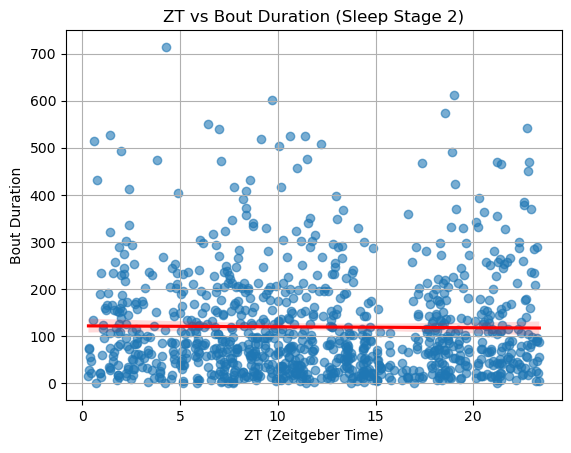

Sleep Stage 3: Pearson Correlation = 0.02, Spearman Correlation = 0.05


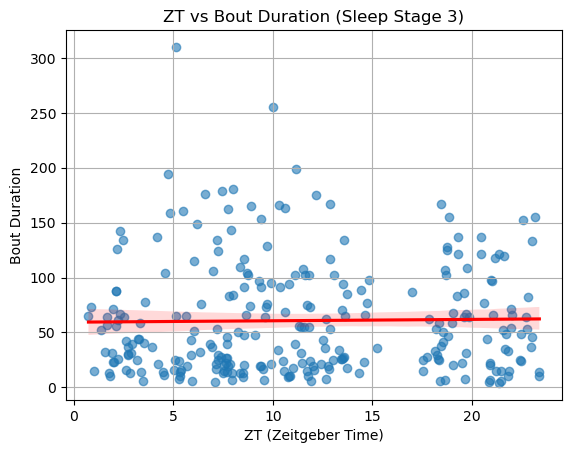

In [12]:
# Determining correlation for individual file

import numpy as np
from scipy.stats import spearmanr, pearsonr
import seaborn as sns

def analyze_relationship(bout_data):
    """
    Analyze the relationship between ZT and bout duration for each sleep stage.

    Args:
        bout_data (list): List of dictionaries containing `ZT`, `Duration`, and `sleepStage`.
    """
    sleep_stages = sorted(set(bout['sleepStage'] for bout in bout_data))

    for stage in sleep_stages:
        stage_data = [bout for bout in bout_data if bout['sleepStage'] == stage]
        zt_values = [bout['ZT'] for bout in stage_data]
        durations = [bout['Duration'] for bout in stage_data]

        # Calculate correlation
        pearson_corr, _ = pearsonr(zt_values, durations)
        spearman_corr, _ = spearmanr(zt_values, durations)
        print(f"Sleep Stage {stage}: Pearson Correlation = {pearson_corr:.2f}, Spearman Correlation = {spearman_corr:.2f}")

        # Scatter plot with trend line
        plt.figure()
        sns.regplot(x=zt_values, y=durations, scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
        plt.title(f'ZT vs Bout Duration (Sleep Stage {stage})')
        plt.xlabel('ZT (Zeitgeber Time)')
        plt.ylabel('Bout Duration')
        plt.grid(True)
        plt.show()

# Example analysis
analyze_relationship(bout_durations)


Sleep Stage 1: Pearson Correlation = 0.06, Spearman Correlation = 0.01


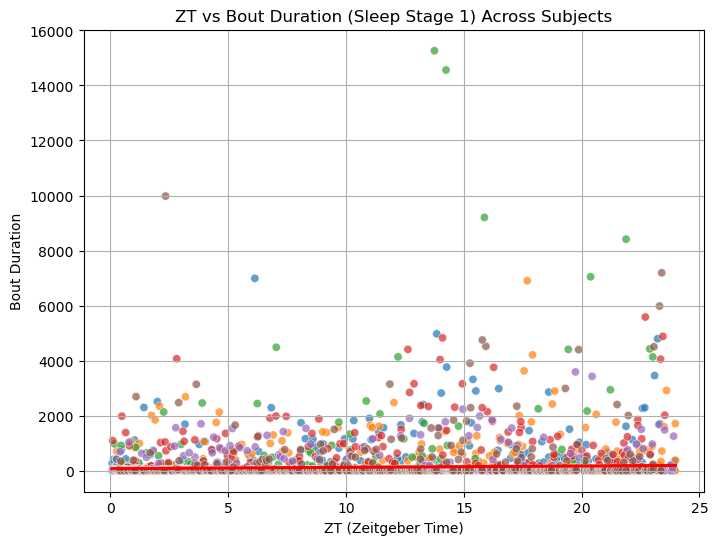

Sleep Stage 2: Pearson Correlation = -0.05, Spearman Correlation = -0.05


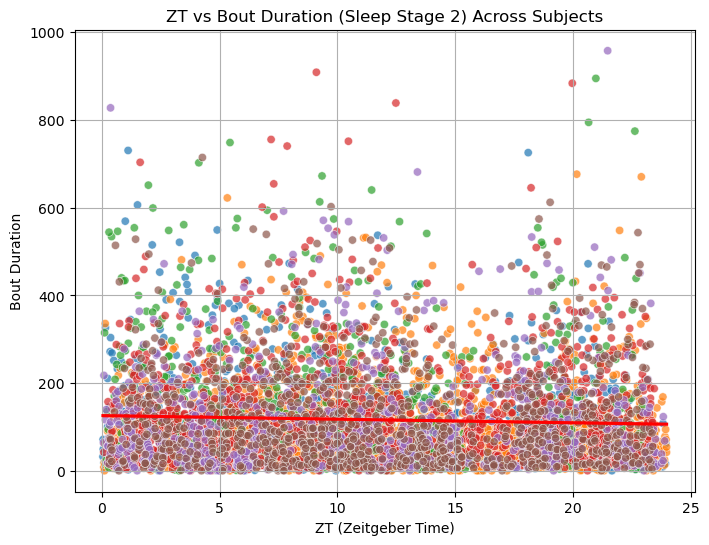

Sleep Stage 3: Pearson Correlation = -0.02, Spearman Correlation = -0.02


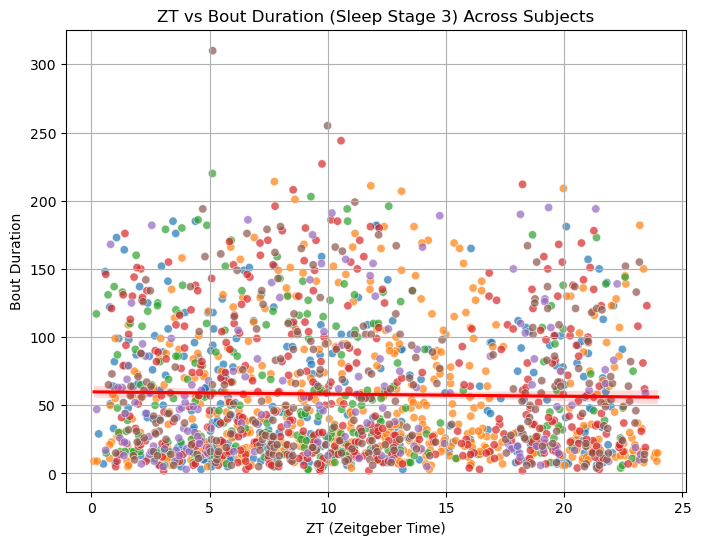

In [ ]:
# Determining multiple files if there is a correlation for each sleep stage with ZT

import csv
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr, pearsonr
import seaborn as sns

def calculate_bout_durations_from_csv(file_path):
    """
    Calculate bout durations for each sleep stage based on continuous values from a CSV file.

    Args:
        file_path (str): Path to the CSV file. The file must have columns `Timestamp` and `sleepStage`.

    Returns:
        list: A list of dictionaries where each dictionary represents a bout with `Timestamp`, `Duration`, `sleepStage`, and `ZT`.
    """
    def calculate_zt(timestamp):
        """
        Calculate the ZT (Zeitgeber Time) based on the timestamp.
        ZT 0 corresponds to 09:00:00 and ZT 12 corresponds to 21:00:00.

        Args:
            timestamp (str): Timestamp in the format 'HH:MM:SS'.

        Returns:
            float: The ZT value.
        """
        base_time = datetime.strptime("09:00:00", "%H:%M:%S")
        current_time = datetime.strptime(timestamp.split()[1], "%H:%M:%S")
        delta = current_time - base_time

        if delta.days < 0:  # Handle times past midnight
            delta += timedelta(days=1)

        zt = (delta.total_seconds() / 3600) % 24
        return zt

    # Read the data from the CSV
    with open(file_path, mode='r') as file:
        reader = csv.DictReader(file)
        data = [(row['Timestamp'], int(row['sleepStage'])) for row in reader]

    if not data:
        return []

    # Initialize variables
    bouts = []
    start_timestamp = data[0][0]  # Start timestamp of the current bout
    current_stage = data[0][1]   # Current sleep stage
    bout_length = 1              # Length of the current bout

    # Iterate through the data starting from the second element
    for i in range(1, len(data)):
        timestamp, sleep_stage = data[i]

        if sleep_stage == current_stage:
            # Increment bout length if the stage is continuous
            bout_length += 1
        else:
            # Append the bout as a dictionary
            bouts.append({
                'Timestamp': start_timestamp,
                'Duration': bout_length,
                'sleepStage': current_stage,
                'ZT': calculate_zt(start_timestamp)
            })

            # Reset for the next bout
            start_timestamp = timestamp
            current_stage = sleep_stage
            bout_length = 1

    # Add the final bout to the result
    bouts.append({
        'Timestamp': start_timestamp,
        'Duration': bout_length,
        'sleepStage': current_stage,
        'ZT': calculate_zt(start_timestamp)
    })

    return bouts


def analyze_relationship(bout_data, subject_labels):
    """
    Analyze the relationship between ZT and bout duration for each sleep stage across all subjects.
    Args:
        bout_data (list): List of lists containing dictionaries for each subject.
        subject_labels (list): List of subject identifiers corresponding to the bout data.
    """
    sleep_stages = sorted(set(bout['sleepStage'] for subject_data in bout_data for bout in subject_data))

    # Create a mapping from subject labels to numeric values for hue
    subject_label_map = {subject_labels[i]: i for i in range(len(subject_labels))}

    # Loop through each sleep stage
    for stage in sleep_stages:
        zt_values = []
        durations = []
        labels = []  # To store the numeric subject label for each point

        for idx, subject_data in enumerate(bout_data):
            stage_data = [bout for bout in subject_data if bout['sleepStage'] == stage]
            zt_values.extend(bout['ZT'] for bout in stage_data)
            durations.extend(bout['Duration'] for bout in stage_data)
            labels.extend([subject_labels[idx]] * len(stage_data))  # Use the actual subject label

        # Calculate correlation
        pearson_corr, _ = pearsonr(zt_values, durations)
        spearman_corr, _ = spearmanr(zt_values, durations)
        print(f"Sleep Stage {stage}: Pearson Correlation = {pearson_corr:.2f}, Spearman Correlation = {spearman_corr:.2f}")

        # Create a Seaborn DataFrame for plotting
        import pandas as pd
        plot_data = pd.DataFrame({
            'ZT': zt_values,
            'Duration': durations,
            'Subject': labels
        })

        # Scatter plot with regression line
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=plot_data, x='ZT', y='Duration', hue='Subject', palette='tab10', alpha=0.7, legend=False)
        sns.regplot(data=plot_data, x='ZT', y='Duration', scatter=False, line_kws={'color': 'red'})

        # Title and labels
        plt.title(f'ZT vs Bout Duration (Sleep Stage {stage}) Across Subjects')
        plt.xlabel('ZT (Zeitgeber Time)')
        plt.ylabel('Bout Duration')

        plt.grid(True)
        plt.show()

# Example usage:
file_paths = [
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-011_ses-01_recording-01_time-0-72h_sr-1hz.csv",
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-016_ses-02_recording-01_time-0-91h_sr-1hz.csv",
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-010_ses-01_recording-01_time-0-69h_sr-1hz.csv",
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-017_ses-01_recording-01_time-0-98h_sr-1hz.csv",
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-015_ses-01_recording-01_time-0-49h_sr-1hz_stitched.csv",
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-007_ses-01_recording-01_time-0-70.5h_sr-1hz.csv"
]  # Add more file paths as needed
subject_labels = ["011", "016","010","017", "015","007"]  # Replace with subject identifiers

all_bout_data = [calculate_bout_durations_from_csv(file_path) for file_path in file_paths]
analyze_relationship(all_bout_data, subject_labels)


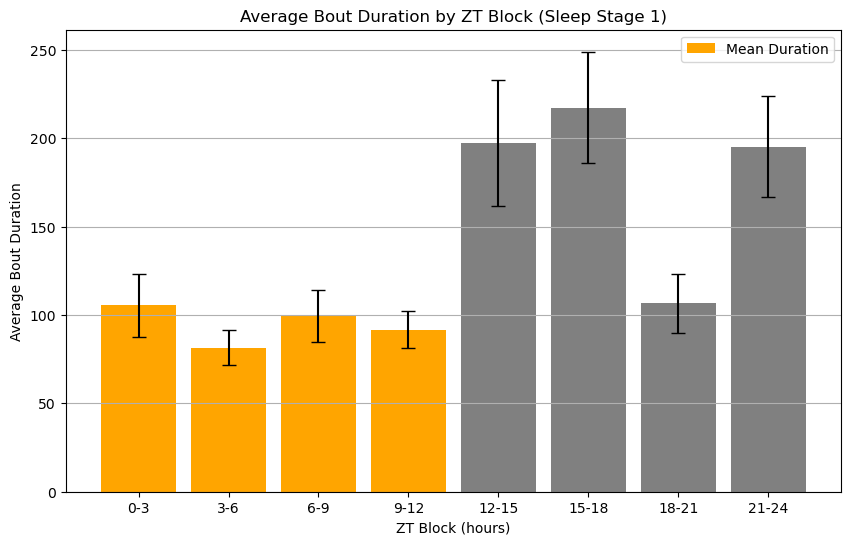

Sleep Stage 1 Repeated Measures ANOVA:
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
ZT_Block  4.6501 7.0000 35.0000 0.0009

Tukey HSD Post-hoc Test (Sleep Stage 1):
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------
     0     12  135.0547 0.5065  -82.8393 352.9488  False
     0     15  184.3047 0.1512  -33.5894 402.1987  False
     0     18   11.1699    1.0 -206.7242  229.064  False
     0     21  131.1598 0.5433  -86.7342 349.0539  False
     0      3  -26.8701 0.9999 -244.7641  191.024  False
     0      6    7.7364    1.0 -210.1577 225.6304  False
     0      9   -15.297    1.0 -233.1911  202.597  False
    12     15   49.2499 0.9958 -168.6441  267.144  False
    12     18 -123.8848 0.6125 -341.7789  94.0092  False
    12     21   -3.8949    1.0  -221.789 213.9992  False
    12      3 -161.9248 0.2808 -379.818

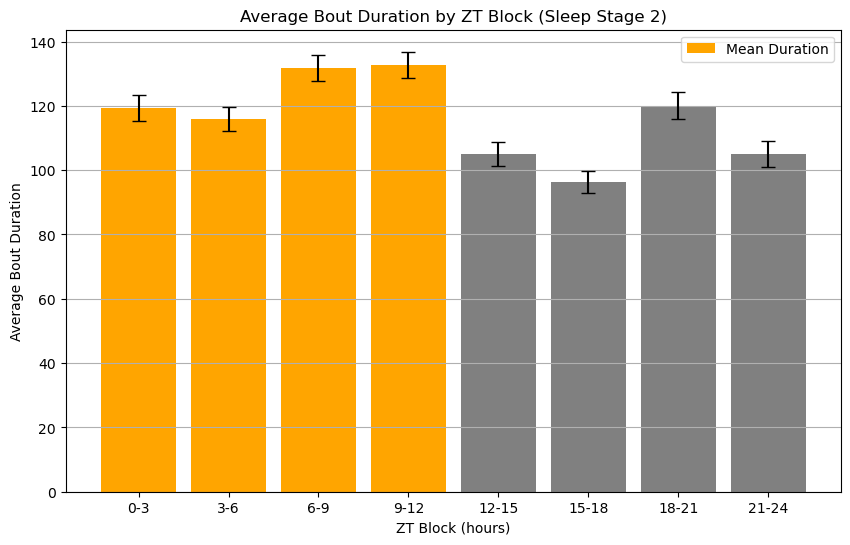

Sleep Stage 2 Repeated Measures ANOVA:
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
ZT_Block  3.8825 7.0000 35.0000 0.0032

Tukey HSD Post-hoc Test (Sleep Stage 2):
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0     12 -16.9297 0.9567 -66.8838 33.0244  False
     0     15 -25.3388 0.7349 -75.2929 24.6153  False
     0     18   0.3462    1.0 -49.6079 50.3003  False
     0     21  -9.7865 0.9983 -59.7406 40.1676  False
     0      3  -6.7746 0.9998 -56.7287 43.1795  False
     0      6   9.6048 0.9985 -40.3493 59.5589  False
     0      9  11.2154 0.9959 -38.7387 61.1695  False
    12     15  -8.4091 0.9994 -58.3632  41.545  False
    12     18  17.2759 0.9519 -32.6782 67.2299  False
    12     21   7.1432 0.9998 -42.8109 57.0973  False
    12      3  10.1551 0.9978  -39.799 60.1091  False
    12      6  26.5345 0

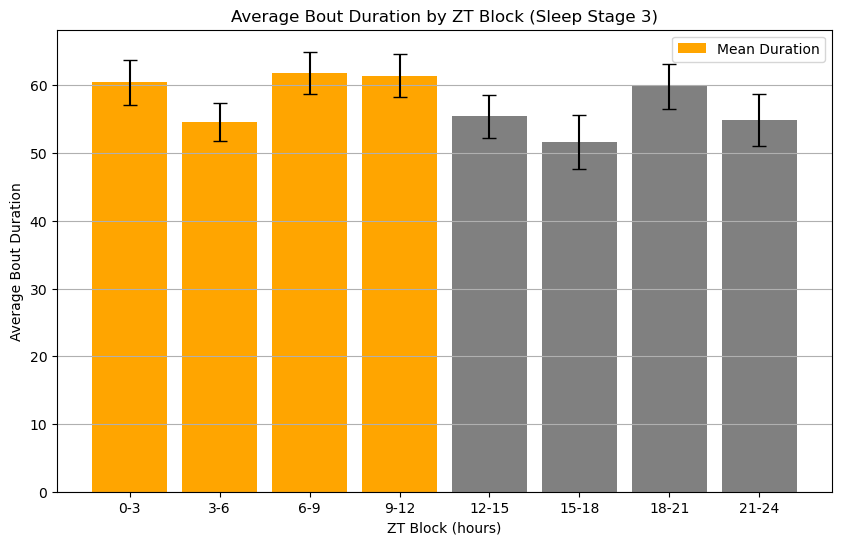

Sleep Stage 3 Repeated Measures ANOVA:
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
ZT_Block  1.7249 7.0000 35.0000 0.1351

Tukey HSD Post-hoc Test (Sleep Stage 3):
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0     12  -2.9886  0.999 -19.5109 13.5338  False
     0     15 -11.8783 0.3198 -28.4006   4.644  False
     0     18  -0.4095    1.0 -16.9319 16.1128  False
     0     21  -1.8218    1.0 -18.3442 14.7005  False
     0      3  -5.9057  0.943  -22.428 10.6167  False
     0      6   2.6651 0.9995 -13.8572 19.1875  False
     0      9   2.3762 0.9998 -14.1462 18.8985  False
    12     15  -8.8897 0.6748 -25.4121  7.6326  False
    12     18    2.579 0.9996 -13.9433 19.1014  False
    12     21   1.1667    1.0 -15.3556 17.6891  False
    12      3  -2.9171 0.9991 -19.4394 13.6052  False
    12      6   5.6537 0

In [17]:
# Determining multiple files bout duration across ZT using bar chart

import csv
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.formula.api import ols
import statsmodels.api as sm

def calculate_bout_durations_from_csv(file_path):
    """
    Calculate bout durations for each sleep stage based on continuous values from a CSV file.

    Args:
        file_path (str): Path to the CSV file. The file must have columns `Timestamp` and `sleepStage`.

    Returns:
        list: A list of dictionaries where each dictionary represents a bout with `Timestamp`, `Duration`, `sleepStage`, and `ZT`.
    """
    def calculate_zt(timestamp):
        """
        Calculate the ZT (Zeitgeber Time) based on the timestamp.
        ZT 0 corresponds to 09:00:00 and ZT 12 corresponds to 21:00:00.

        Args:
            timestamp (str): Timestamp in the format 'HH:MM:SS'.

        Returns:
            float: The ZT value.
        """
        base_time = datetime.strptime("09:00:00", "%H:%M:%S")
        current_time = datetime.strptime(timestamp.split()[1], "%H:%M:%S")
        delta = current_time - base_time

        if delta.days < 0:  # Handle times past midnight
            delta += timedelta(days=1)

        zt = (delta.total_seconds() / 3600) % 24
        return zt

    # Read the data from the CSV
    with open(file_path, mode='r') as file:
        reader = csv.DictReader(file)
        data = [(row['Timestamp'], int(row['sleepStage'])) for row in reader]

    if not data:
        return []

    # Initialize variables
    bouts = []
    start_timestamp = data[0][0]  # Start timestamp of the current bout
    current_stage = data[0][1]   # Current sleep stage
    bout_length = 1              # Length of the current bout

    # Iterate through the data starting from the second element
    for i in range(1, len(data)):
        timestamp, sleep_stage = data[i]

        if sleep_stage == current_stage:
            # Increment bout length if the stage is continuous
            bout_length += 1
        else:
            # Append the bout as a dictionary
            bouts.append({
                'Timestamp': start_timestamp,
                'Duration': bout_length,
                'sleepStage': current_stage,
                'ZT': calculate_zt(start_timestamp)
            })

            # Reset for the next bout
            start_timestamp = timestamp
            current_stage = sleep_stage
            bout_length = 1

    # Add the final bout to the result
    bouts.append({
        'Timestamp': start_timestamp,
        'Duration': bout_length,
        'sleepStage': current_stage,
        'ZT': calculate_zt(start_timestamp)
    })

    return bouts

def analyze_relationship_with_bar_charts_and_repeated_measures_anova(bout_data, subject_labels):
    """
    Create bar charts for ZT (divided into 3-hour blocks) and bout durations for each sleep stage across subjects.
    Perform repeated measures ANOVA and post-hoc tests for each sleep stage.

    Args:
        bout_data (list): List of lists containing dictionaries for each subject.
        subject_labels (list): List of subject identifiers corresponding to the bout data.
    """
    sleep_stages = sorted(set(bout['sleepStage'] for subject_data in bout_data for bout in subject_data))

    # Group ZT into 3-hour blocks
    def zt_to_block(zt):
        return int(zt // 3) * 3

    for stage in sleep_stages:
        zt_blocks = []
        durations = []
        subjects = []

        for idx, subject_data in enumerate(bout_data):
            stage_data = [bout for bout in subject_data if bout['sleepStage'] == stage]
            zt_blocks.extend(zt_to_block(bout['ZT']) for bout in stage_data)
            durations.extend(bout['Duration'] for bout in stage_data)
            subjects.extend([subject_labels[idx]] * len(stage_data))

        # Create a DataFrame for analysis
        plot_data = pd.DataFrame({
            'Subject': subjects,
            'ZT Block': zt_blocks,
            'Duration': durations
        })

        # Ensure all ZT blocks are represented
        all_blocks = range(0, 24, 3)
        grouped_data = plot_data.groupby(['Subject', 'ZT Block'])['Duration'].mean().unstack(fill_value=0)

        # Bar chart
        summary_data = plot_data.groupby('ZT Block')['Duration'].agg(['mean', sem]).reindex(all_blocks, fill_value=0)
        summary_data['ZT Block'] = summary_data.index

        plt.figure(figsize=(10, 6))
        colors = ['orange'] * 4 + ['grey'] * 4
        plt.bar(summary_data['ZT Block'], summary_data['mean'], color=colors, width=2.5, align='center', label='Mean Duration')

        # Add error bars for SEM
        plt.errorbar(x=summary_data['ZT Block'], y=summary_data['mean'], yerr=summary_data['sem'], fmt='none', ecolor='black', capsize=5)

        # Title and labels
        plt.title(f'Average Bout Duration by ZT Block (Sleep Stage {stage})')
        plt.xlabel('ZT Block (hours)')
        plt.ylabel('Average Bout Duration')

        plt.xticks(ticks=np.arange(0, 24, 3), labels=[f'{i}-{i+3}' for i in range(0, 24, 3)])
        plt.grid(axis='y')
        plt.legend()
        plt.show()

        # Repeated measures ANOVA
        melted_data = grouped_data.reset_index().melt(id_vars='Subject', var_name='ZT_Block', value_name='Duration')
        melted_data['ZT_Block'] = melted_data['ZT_Block'].astype(str)  # Ensure ZT Block is categorical
        anova_model = AnovaRM(melted_data, depvar='Duration', subject='Subject', within=['ZT_Block'])
        anova_result = anova_model.fit()
        print(f"Sleep Stage {stage} Repeated Measures ANOVA:")
        print(anova_result)

        # Post-hoc pairwise comparisons
        mc = MultiComparison(melted_data['Duration'], melted_data['ZT_Block'])
        tukey_result = mc.tukeyhsd()
        print(f"Tukey HSD Post-hoc Test (Sleep Stage {stage}):")
        print(tukey_result.summary())


# Example usage:
file_paths = [
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-011_ses-01_recording-01_time-0-72h_sr-1hz.csv",
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-016_ses-02_recording-01_time-0-91h_sr-1hz.csv",
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-010_ses-01_recording-01_time-0-69h_sr-1hz.csv",
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-017_ses-01_recording-01_time-0-98h_sr-1hz.csv",
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-015_ses-01_recording-01_time-0-49h_sr-1hz_stitched.csv",
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-007_ses-01_recording-01_time-0-70.5h_sr-1hz.csv"
]  # Add more file paths as needed
subject_labels = ["011", "016", "010", "017", "015", "007"]  # Replace with subject identifiers

all_bout_data = [calculate_bout_durations_from_csv(file_path) for file_path in file_paths]
analyze_relationship_with_bar_charts_and_repeated_measures_anova(all_bout_data, subject_labels)



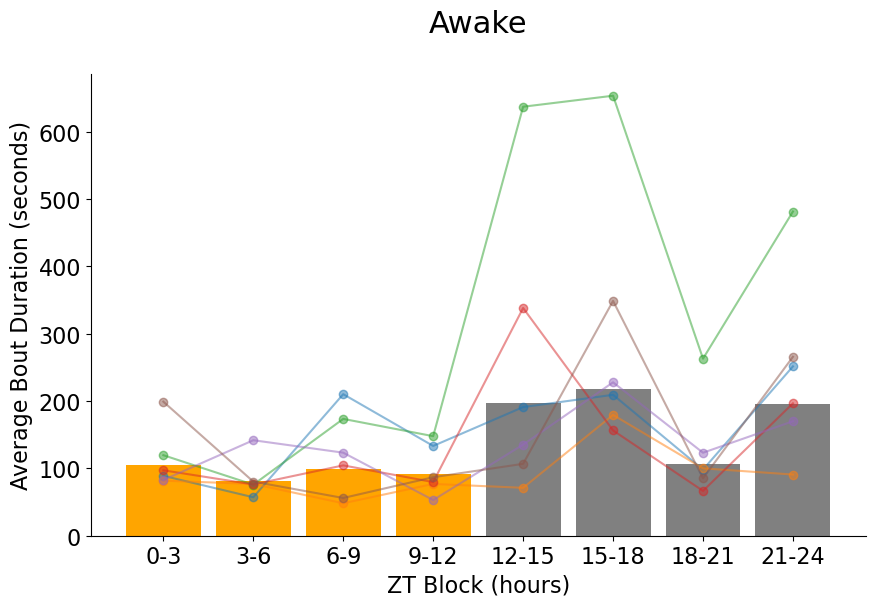

Awake Repeated Measures ANOVA:
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
ZT_Block  4.6501 7.0000 35.0000 0.0009

Tukey HSD Post-hoc Test (Awake):
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------
     0     12  135.0547 0.5065  -82.8393 352.9488  False
     0     15  184.3047 0.1512  -33.5894 402.1987  False
     0     18   11.1699    1.0 -206.7242  229.064  False
     0     21  131.1598 0.5433  -86.7342 349.0539  False
     0      3  -26.8701 0.9999 -244.7641  191.024  False
     0      6    7.7364    1.0 -210.1577 225.6304  False
     0      9   -15.297    1.0 -233.1911  202.597  False
    12     15   49.2499 0.9958 -168.6441  267.144  False
    12     18 -123.8848 0.6125 -341.7789  94.0092  False
    12     21   -3.8949    1.0  -221.789 213.9992  False
    12      3 -161.9248 0.2808 -379.8188  55.9693  Fals

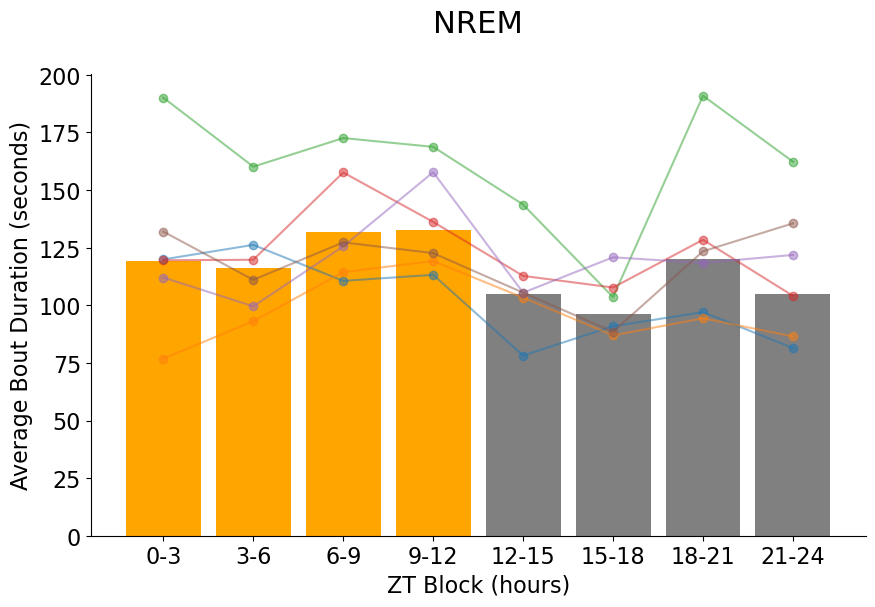

NREM Repeated Measures ANOVA:
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
ZT_Block  3.8825 7.0000 35.0000 0.0032

Tukey HSD Post-hoc Test (NREM):
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0     12 -16.9297 0.9567 -66.8838 33.0244  False
     0     15 -25.3388 0.7349 -75.2929 24.6153  False
     0     18   0.3462    1.0 -49.6079 50.3003  False
     0     21  -9.7865 0.9983 -59.7406 40.1676  False
     0      3  -6.7746 0.9998 -56.7287 43.1795  False
     0      6   9.6048 0.9985 -40.3493 59.5589  False
     0      9  11.2154 0.9959 -38.7387 61.1695  False
    12     15  -8.4091 0.9994 -58.3632  41.545  False
    12     18  17.2759 0.9519 -32.6782 67.2299  False
    12     21   7.1432 0.9998 -42.8109 57.0973  False
    12      3  10.1551 0.9978  -39.799 60.1091  False
    12      6  26.5345 0.6885 -23.4196 76.

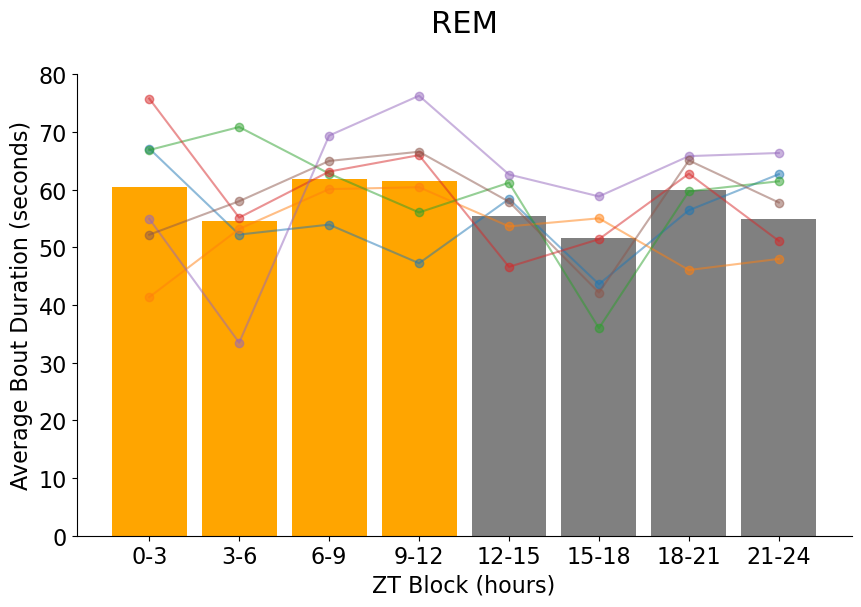

REM Repeated Measures ANOVA:
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
ZT_Block  1.7249 7.0000 35.0000 0.1351

Tukey HSD Post-hoc Test (REM):
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0     12  -2.9886  0.999 -19.5109 13.5338  False
     0     15 -11.8783 0.3198 -28.4006   4.644  False
     0     18  -0.4095    1.0 -16.9319 16.1128  False
     0     21  -1.8218    1.0 -18.3442 14.7005  False
     0      3  -5.9057  0.943  -22.428 10.6167  False
     0      6   2.6651 0.9995 -13.8572 19.1875  False
     0      9   2.3762 0.9998 -14.1462 18.8985  False
    12     15  -8.8897 0.6748 -25.4121  7.6326  False
    12     18    2.579 0.9996 -13.9433 19.1014  False
    12     21   1.1667    1.0 -15.3556 17.6891  False
    12      3  -2.9171 0.9991 -19.4394 13.6052  False
    12      6   5.6537 0.9544 -10.8687  22.1

In [34]:
import csv
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.formula.api import ols
import statsmodels.api as sm

def calculate_bout_durations_from_csv(file_path):
    """
    Calculate bout durations for each sleep stage based on continuous values from a CSV file.
    """
    def calculate_zt(timestamp):
        """
        Calculate the ZT (Zeitgeber Time) based on the timestamp.
        """
        base_time = datetime.strptime("09:00:00", "%H:%M:%S")
        current_time = datetime.strptime(timestamp.split()[1], "%H:%M:%S")
        delta = current_time - base_time

        if delta.days < 0:  # Handle times past midnight
            delta += timedelta(days=1)

        zt = (delta.total_seconds() / 3600) % 24
        return zt

    # Read the data from the CSV
    with open(file_path, mode='r') as file:
        reader = csv.DictReader(file)
        data = [(row['Timestamp'], int(row['sleepStage'])) for row in reader]

    if not data:
        return []

    # Initialize variables
    bouts = []
    start_timestamp = data[0][0]  # Start timestamp of the current bout
    current_stage = data[0][1]   # Current sleep stage
    bout_length = 1              # Length of the current bout

    # Iterate through the data starting from the second element
    for i in range(1, len(data)):
        timestamp, sleep_stage = data[i]

        if sleep_stage == current_stage:
            # Increment bout length if the stage is continuous
            bout_length += 1
        else:
            # Append the bout as a dictionary
            bouts.append({
                'Timestamp': start_timestamp,
                'Duration': bout_length,
                'sleepStage': current_stage,
                'ZT': calculate_zt(start_timestamp)
            })

            # Reset for the next bout
            start_timestamp = timestamp
            current_stage = sleep_stage
            bout_length = 1

    # Add the final bout to the result
    bouts.append({
        'Timestamp': start_timestamp,
        'Duration': bout_length,
        'sleepStage': current_stage,
        'ZT': calculate_zt(start_timestamp)
    })

    return bouts

def analyze_relationship_with_bar_charts_and_repeated_measures_anova(bout_data, subject_labels):
    """
    Create bar charts for ZT (divided into 3-hour blocks) and bout durations for each sleep stage across subjects.
    Perform repeated measures ANOVA and post-hoc tests for each sleep stage.
    """
    # Mapping sleep stages to names
    sleep_stage_map = {1: 'Awake', 2: 'NREM', 3: 'REM'}
    
    sleep_stages = sorted(set(bout['sleepStage'] for subject_data in bout_data for bout in subject_data))

    # Group ZT into 3-hour blocks
    def zt_to_block(zt):
        return int(zt // 3) * 3

    for stage in sleep_stages:
        # Map sleep stage to name
        stage_name = sleep_stage_map.get(stage, f"Stage {stage}")
        
        zt_blocks = []
        durations = []
        subjects = []

        # Collect data for plotting and analysis
        for idx, subject_data in enumerate(bout_data):
            stage_data = [bout for bout in subject_data if bout['sleepStage'] == stage]
            zt_blocks.extend(zt_to_block(bout['ZT']) for bout in stage_data)
            durations.extend(bout['Duration'] for bout in stage_data)
            subjects.extend([subject_labels[idx]] * len(stage_data))

        # Create a DataFrame for analysis
        plot_data = pd.DataFrame({
            'Subject': subjects,
            'ZT Block': zt_blocks,
            'Duration': durations
        })

        # Ensure all ZT blocks are represented
        all_blocks = range(0, 24, 3)
        grouped_data = plot_data.groupby(['Subject', 'ZT Block'])['Duration'].mean().unstack(fill_value=0)

        # Bar chart for mean duration per ZT block
        summary_data = plot_data.groupby('ZT Block')['Duration'].agg(['mean', sem]).reindex(all_blocks, fill_value=0)
        summary_data['ZT Block'] = summary_data.index

        plt.figure(figsize=(10, 6))
        colors = ['orange'] * 4 + ['grey'] * 4
        plt.bar(summary_data['ZT Block'], summary_data['mean'], color=colors, width=2.5, align='center', label='Mean Duration')

        # Plot mean for each subject (use a line or different markers)
        for idx, subject_data in enumerate(bout_data):
            subject_stage_data = [bout for bout in subject_data if bout['sleepStage'] == stage]
            subject_zt_blocks = [zt_to_block(bout['ZT']) for bout in subject_stage_data]
            subject_durations = [bout['Duration'] for bout in subject_stage_data]

            # Calculate the mean for each subject per ZT block
            subject_means = [np.mean([d for z, d in zip(subject_zt_blocks, subject_durations) if z == block]) for block in all_blocks]

            # Plot mean for each subject (use a line or different markers)
            plt.plot(all_blocks, subject_means, marker='o', linestyle='-', alpha=0.5)

        # Title and labels
        plt.title(f'{stage_name}', fontsize=22, pad=30)
        plt.xlabel('ZT Block (hours)', fontsize=16)
        plt.ylabel('Average Bout Duration (seconds)', fontsize=16)

        plt.xticks(ticks=np.arange(0, 24, 3), labels=[f'{i}-{i+3}' for i in range(0, 24, 3)], fontsize=16)
        plt.tick_params(axis='y', labelsize=16)
    

        # Remove top and right spines
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Show the plot without the legend
        plt.show()

        # Repeated measures ANOVA
        melted_data = grouped_data.reset_index().melt(id_vars='Subject', var_name='ZT_Block', value_name='Duration')
        melted_data['ZT_Block'] = melted_data['ZT_Block'].astype(str)  # Ensure ZT Block is categorical
        anova_model = AnovaRM(melted_data, depvar='Duration', subject='Subject', within=['ZT_Block'])
        anova_result = anova_model.fit()
        print(f"{stage_name} Repeated Measures ANOVA:")
        print(anova_result)

        # Post-hoc pairwise comparisons
        mc = MultiComparison(melted_data['Duration'], melted_data['ZT_Block'])
        tukey_result = mc.tukeyhsd()
        print(f"Tukey HSD Post-hoc Test ({stage_name}):")
        print(tukey_result.summary())


# Example usage:
file_paths = [
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-011_ses-01_recording-01_time-0-72h_sr-1hz.csv",
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-016_ses-02_recording-01_time-0-91h_sr-1hz.csv",
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-010_ses-01_recording-01_time-0-69h_sr-1hz.csv",
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-017_ses-01_recording-01_time-0-98h_sr-1hz.csv",
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-015_ses-01_recording-01_time-0-49h_sr-1hz_stitched.csv",
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-007_ses-01_recording-01_time-0-70.5h_sr-1hz.csv"
]  # Add more file paths as needed
subject_labels = ["011", "016", "017", "010", "015", "007"]  # Replace with subject identifiers

all_bout_data = [calculate_bout_durations_from_csv(file_path) for file_path in file_paths]
analyze_relationship_with_bar_charts_and_repeated_measures_anova(all_bout_data, subject_labels)


Sleep Stage 1 - Light Phase (ZT 0-12):
  Pearson Correlation: -0.01
  Spearman Correlation: -0.06


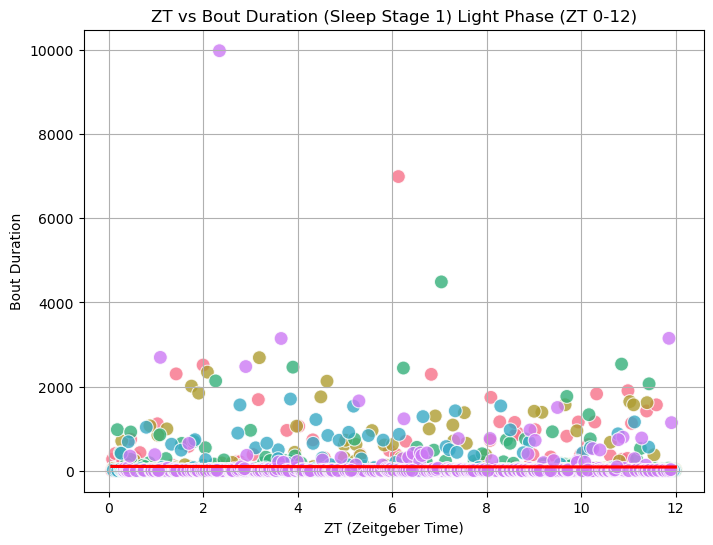

Sleep Stage 1 - Dark Phase (ZT 12-24):
  Pearson Correlation: 0.00
  Spearman Correlation: 0.01


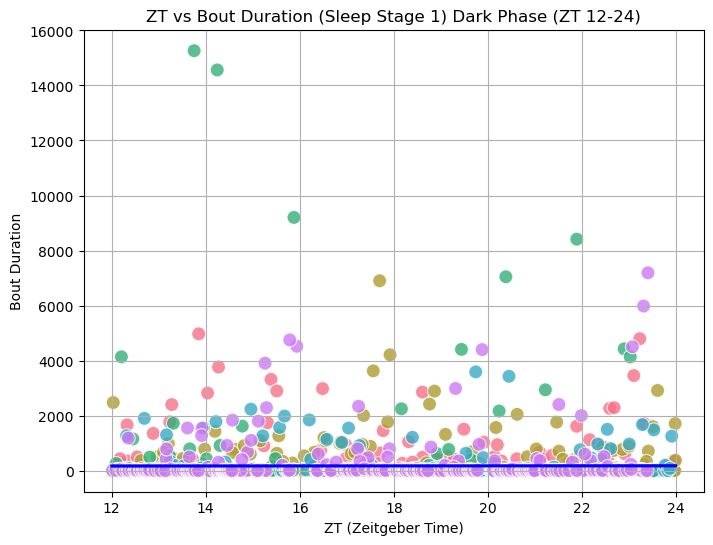

Sleep Stage 2 - Light Phase (ZT 0-12):
  Pearson Correlation: 0.05
  Spearman Correlation: 0.06


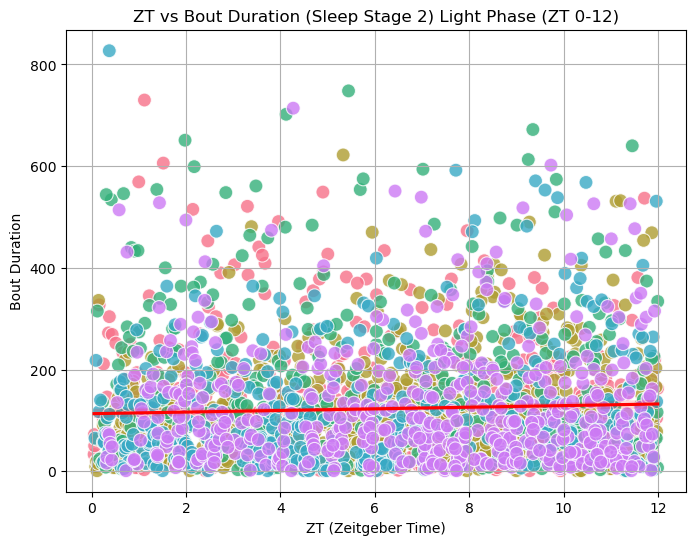

Sleep Stage 2 - Dark Phase (ZT 12-24):
  Pearson Correlation: 0.02
  Spearman Correlation: 0.00


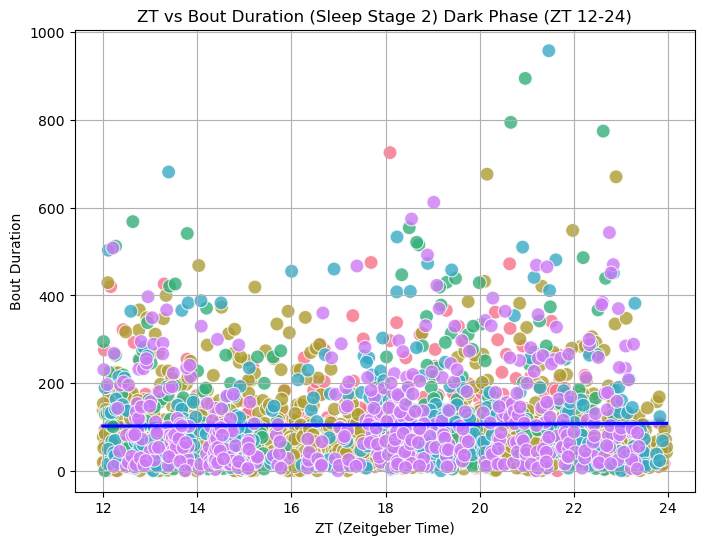

Sleep Stage 3 - Light Phase (ZT 0-12):
  Pearson Correlation: 0.04
  Spearman Correlation: 0.03


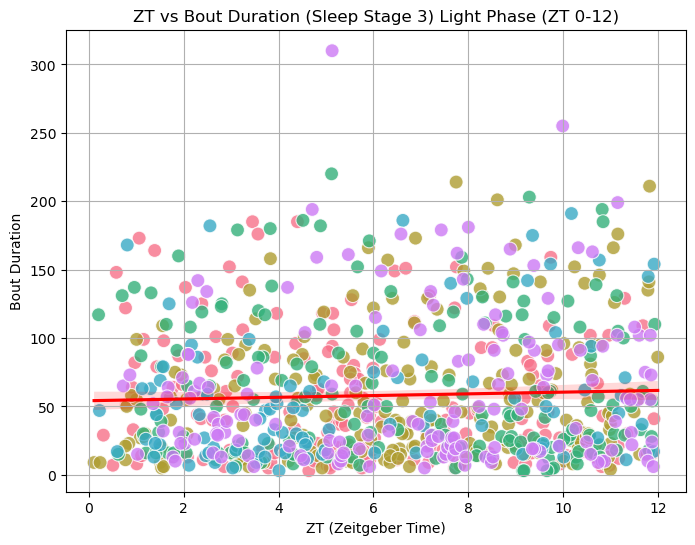

Sleep Stage 3 - Dark Phase (ZT 12-24):
  Pearson Correlation: -0.02
  Spearman Correlation: -0.04


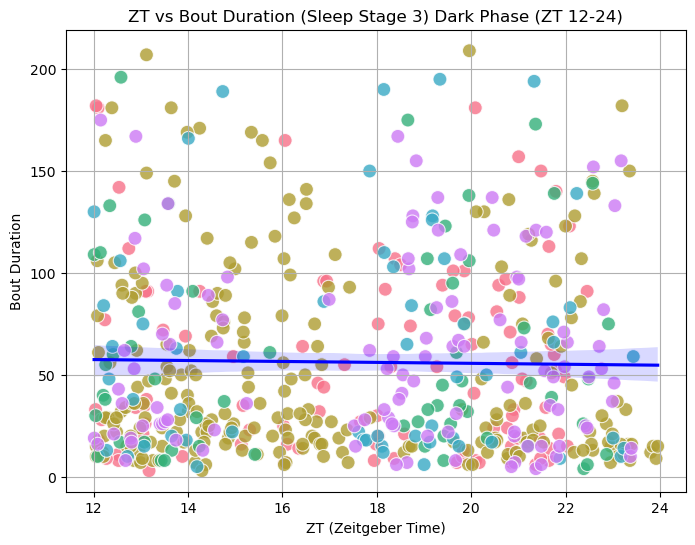

In [47]:
# Determining multiple files if there is a correlation for each sleep stage with ZT - separating into light and dark

import csv
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr, pearsonr
import seaborn as sns
import pandas as pd

def calculate_bout_durations_from_csv(file_path, subject_label):
    """
    Calculate bout durations for each sleep stage based on continuous values from a CSV file.

    Args:
        file_path (str): Path to the CSV file. The file must have columns `Timestamp` and `sleepStage`.
        subject_label (str): The label to identify the subject.

    Returns:
        list: A list of dictionaries where each dictionary represents a bout with `Timestamp`, `Duration`, `sleepStage`, `ZT`, and `Subject`.
    """
    def calculate_zt(timestamp):
        """
        Calculate the ZT (Zeitgeber Time) based on the timestamp.
        ZT 0 corresponds to 09:00:00 and ZT 12 corresponds to 21:00:00.

        Args:
            timestamp (str): Timestamp in the format 'HH:MM:SS'.

        Returns:
            float: The ZT value.
        """
        base_time = datetime.strptime("09:00:00", "%H:%M:%S")
        current_time = datetime.strptime(timestamp.split()[1], "%H:%M:%S")
        delta = current_time - base_time

        if delta.days < 0:  # Handle times past midnight
            delta += timedelta(days=1)

        zt = (delta.total_seconds() / 3600) % 24
        return zt

    # Read the data from the CSV
    with open(file_path, mode='r') as file:
        reader = csv.DictReader(file)
        data = [(row['Timestamp'], int(row['sleepStage'])) for row in reader]

    if not data:
        return []

    # Initialize variables
    bouts = []
    start_timestamp = data[0][0]  # Start timestamp of the current bout
    current_stage = data[0][1]   # Current sleep stage
    bout_length = 1              # Length of the current bout

    # Iterate through the data starting from the second element
    for i in range(1, len(data)):
        timestamp, sleep_stage = data[i]

        if sleep_stage == current_stage:
            # Increment bout length if the stage is continuous
            bout_length += 1
        else:
            # Append the bout as a dictionary
            bouts.append({
                'Timestamp': start_timestamp,
                'Duration': bout_length,
                'sleepStage': current_stage,
                'ZT': calculate_zt(start_timestamp),
                'Subject': subject_label
            })

            # Reset for the next bout
            start_timestamp = timestamp
            current_stage = sleep_stage
            bout_length = 1

    # Add the final bout to the result
    bouts.append({
        'Timestamp': start_timestamp,
        'Duration': bout_length,
        'sleepStage': current_stage,
        'ZT': calculate_zt(start_timestamp),
        'Subject': subject_label
    })

    return bouts

def analyze_relationship(bout_data):
    """
    Analyze the relationship between ZT and bout duration for each sleep stage across all subjects,
    separately for the light phase (ZT 0-12) and dark phase (ZT 12-24).
    
    Args:
        bout_data (list): List of lists containing dictionaries for each subject.
    """
    sleep_stages = sorted(set(bout['sleepStage'] for subject_data in bout_data for bout in subject_data))

    # Convert the bout data to a Pandas DataFrame for easier handling and plotting
    all_bouts = []
    for subject_data in bout_data:
        all_bouts.extend(subject_data)

    df = pd.DataFrame(all_bouts)

    for stage in sleep_stages:
        # Filter the data for the current sleep stage
        stage_data = df[df['sleepStage'] == stage]

        light_phase_data = stage_data[stage_data['ZT'] < 12]
        dark_phase_data = stage_data[stage_data['ZT'] >= 12]

        # Calculate and print correlations for light phase
        if not light_phase_data.empty:
            pearson_corr_light, _ = pearsonr(light_phase_data['ZT'], light_phase_data['Duration'])
            spearman_corr_light, _ = spearmanr(light_phase_data['ZT'], light_phase_data['Duration'])
            
            print(f"Sleep Stage {stage} - Light Phase (ZT 0-12):")
            print(f"  Pearson Correlation: {pearson_corr_light:.2f}")
            print(f"  Spearman Correlation: {spearman_corr_light:.2f}")

            # Scatter plot for light phase using seaborn
            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=light_phase_data, x='ZT', y='Duration', hue='Subject', palette='husl', s=100, alpha=0.8, legend=False)
            sns.regplot(x=light_phase_data['ZT'], y=light_phase_data['Duration'], scatter=False, color='red')

            plt.title(f'ZT vs Bout Duration (Sleep Stage {stage}) Light Phase (ZT 0-12)')
            plt.xlabel('ZT (Zeitgeber Time)')
            plt.ylabel('Bout Duration')
            plt.grid(True)
            plt.show()

        # Calculate and print correlations for dark phase
        if not dark_phase_data.empty:
            pearson_corr_dark, _ = pearsonr(dark_phase_data['ZT'], dark_phase_data['Duration'])
            spearman_corr_dark, _ = spearmanr(dark_phase_data['ZT'], dark_phase_data['Duration'])
            
            print(f"Sleep Stage {stage} - Dark Phase (ZT 12-24):")
            print(f"  Pearson Correlation: {pearson_corr_dark:.2f}")
            print(f"  Spearman Correlation: {spearman_corr_dark:.2f}")

            # Scatter plot for dark phase using seaborn
            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=dark_phase_data, x='ZT', y='Duration', hue='Subject', palette='husl', s=100, alpha=0.8, legend=False)
            sns.regplot(x=dark_phase_data['ZT'], y=dark_phase_data['Duration'], scatter=False, color='blue')

            plt.title(f'ZT vs Bout Duration (Sleep Stage {stage}) Dark Phase (ZT 12-24)')
            plt.xlabel('ZT (Zeitgeber Time)')
            plt.ylabel('Bout Duration')
            plt.grid(True)
            plt.show()

# Example usage:
file_paths = [
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-011_ses-01_recording-01_time-0-72h_sr-1hz.csv",
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-016_ses-02_recording-01_time-0-91h_sr-1hz.csv",
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-010_ses-01_recording-01_time-0-69h_sr-1hz.csv",
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-017_ses-01_recording-01_time-0-98h_sr-1hz.csv",
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-015_ses-01_recording-01_time-0-49h_sr-1hz_stitched.csv",
    "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-007_ses-01_recording-01_time-0-70.5h_sr-1hz.csv"
]  # Add more file paths as needed
subject_labels = ["011", "016","010","017","015","007"]  # Replace with subject identifiers

all_bout_data = [
    calculate_bout_durations_from_csv(file_path, subject_label)
    for file_path, subject_label in zip(file_paths, subject_labels)
]
analyze_relationship(all_bout_data)
